# Setup

## Setup

In [ ]:
# !echo 'debconf debconf/frontend select Noninteractive' | debconf-set-selections
# !sudo apt-get install texlive-latex-recommended texlive-latex-extra dvipng -y >/dev/null
# # https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches

In [ ]:
!ls '041021_full_tests.tar.xz' 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy 'https://drive.google.com/file/d/1CGJjRTumHvTi2mFbxRNIp-MQofhQ9pKy/view?usp=sharing')

Downloading...
From: https://drive.google.com/uc?id=1CGJjRTumHvTi2mFbxRNIp-MQofhQ9pKy
To: /content/041021_full_tests.tar.xz
100% 1.43G/1.43G [00:15<00:00, 90.8MB/s]


In [ ]:
!ls '041021_full_tests/triangle_1/pico.npts' 2>/dev/null 1>/dev/null || tar xvf '041021_full_tests.tar.xz'

041021_full_tests/
041021_full_tests/triangle_1/
041021_full_tests/triangle_1/pico.npts
041021_full_tests/triangle_1/imu.csv
041021_full_tests/triangle_2/
041021_full_tests/triangle_2/pico.npts
041021_full_tests/triangle_2/imu.csv
041021_full_tests/line_1/
041021_full_tests/line_1/pico.npts
041021_full_tests/line_1/imu.csv


In [ ]:
in_file = '041021_full_tests/triangle_2/pico.npts'

In [ ]:
run_name = 'triangle_2'

In [ ]:
!ls -lh {in_file}

-rw-rw-r-- 1 1001 1001 2.3G Oct  5 05:06 041021_full_tests/triangle_2/pico.npts


For ease of use, assuming all data is stored as a 100000 x 5 arrays. I.e. 0.1 s => 100 ms  
Each ping lasts for 3ms and there is a 1s interval b/w start of pings.  
For first buffer, max size req is 1.3 seconds => round to 1.5 s   
Sample rate is 1e6  

In [ ]:
fs = 1e6
dt = 1.0 / fs

<!-- 2 Modes:  
1. "Searching" mode Gives data in 1.3 second (1300 ms) intervals. 
2. "Found Mode" gives data in 1.0 second intervals. The start of  signal should coorrespond with start o  -->

In [ ]:
import numpy as np
import struct


from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n

    def __call__(self, data):
        out = np.empty_like(data)
        for i in range(data.shape[1]):
            out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
        return out

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        # out = np.empty_like(data)
        # for i in range(data.shape[1]):
        #     out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
        return np.abs(hilbert(data))

class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename):  # filename: Union[str, path_like, File object]
        self.filename = filename
        self.file = None
        self.band_pass = BP(fs)
        self.envelope = MA(fs)
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            bp = self.band_pass(arr)
            out = self.envelope(np.abs(bp - bp.mean(axis=0)))
            # out = np.abs(hilbert(bp - bp.mean(axis=0), axis=0))
            return t, out.astype(arr.dtype)
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

In [ ]:
reader = PicoDataLoader(in_file)
reader.open()

## ZC


In [ ]:
import itertools
import numpy as np


# TODO: how to deal with multiple sets of zero crossing,
# TODO: groupby can bre replaced my numpy indexing i think
# notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# stage 1 does the following processes:
# 1. filter use IIR bandpass filters
# 2. estimate the zero-crossing of the first peak in two stages
#    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
#    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# Availible defaults           500,1e6,                    0,
def Est_ZC_stage_1(signal, winsize, std_noise_multiplier, run_plot=False, plot_title='zero_crossing'):
    def sum_index(index_limit, reshaped_group_results_len):
        ind_count = 0
        for k in range(0, index_limit):
            ind_count = ind_count + reshaped_group_results_len[k]
        return ind_count

    def ZC_estimation(signal_h, noise_threshold, n_max_p):

        # estimate out part of the signal which is > threshold
        results = np.where(signal_h > noise_threshold, True, False)

        # itertools groupby aims to group the array in groups of True and False
        # where g is the groups and k is unique key/ value in each group
        # size/ length of the groups is given by len(list(g)) and is stored as an np.array
        group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

        # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
        # for which length are estimated previously
        group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

        # indices & group-length wherein corresponding value in group_results_value is True
        ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
        group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

        # indices of top n_max maximuma of group_len_counts_of_true
        ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

        # manipulations to match the shape of the arrays
        group_len_counts_of_true = group_len_counts_of_true.T
        ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

        # how many maxs (top-n) need to be estimated?
        n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
        if n_max <= 2:
            n_max = int(len(group_len_counts_of_true))

        ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

        # what are the values of the top-n (sorted) group-lengths of trues?
        values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
        values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

        # manipulations to match the shape of the arrays
        reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

        # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
        # comparison with the entire (true-false) list
        ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
                                                                    values_maxes_in_group_results_len)))

        index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
        for i in range(len(ind_of_max_in_group_results_len)):
            try:
                index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
                                                        reshaped_group_results_len) + 1
            except:
                index_max_counts_of_true[i] = 0
                break

        Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

        return Q_zero_cross_index

    def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        index = Q_zero_cross_index
        fig, axs = plt.subplots(1, figsize=(10,4))
        fig.suptitle(plot_title)
        axs.plot(signal_h, label='bandpass')
        axs.plot(np.repeat(0, len(signal_h)), 'k--', label='zero level')
        axs.plot(np.repeat(noise_threshold_1, len(signal_h)), 'r--', label='noise_threshold_1')
        axs.plot(np.repeat(noise_threshold_2, len(signal_h)), 'b--', label='noise_threshold_2')
        axs.plot(index, signal_h[index], 'o')
        rect = Rectangle((index, 0), winsize * 2, np.max(signal_h) / 2, linewidth=3, edgecolor='r', facecolor='none')
        axs.add_patch(rect)
        axs.legend()

    # filter first and then, normalise the signal for further processing
    # estimate the envelope of the rectified signal using the hilbert transform
    # estimate threshold
    threshold = (np.mean(signal))
    signal_noise_h = np.where(signal > threshold, 0, signal)
    noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
    noise_threshold_1 = 200
    # print('noise_threshold_1', noise_threshold_1)

    # first iteration
    n_max_p = 5
    init_est_ZC_index = ZC_estimation(signal, noise_threshold_1, n_max_p)
    # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

    # attempt to check the samples in the neighbourhood
    hori_check_indices = np.linspace(max(init_est_ZC_index - winsize,0), min(init_est_ZC_index + winsize,signal.shape[0] - 1), winsize * 2, dtype=int)
    if np.all(signal[hori_check_indices] < 10 * noise_threshold_1):
        init_est_ZC_index = ZC_estimation(signal, noise_threshold_1 * 2, n_max_p)

    # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
    noise_threshold_2 = noise_threshold_1 * 1.25
    # print('noise_threshold_2', noise_threshold_2)
    second_est_ZC_index = 0
    if signal[init_est_ZC_index] >= 3 * noise_threshold_1:
        # second iteration
        n_max_p = 50
        sub_signal = signal[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
        ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
        # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
        second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
        # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

    if second_est_ZC_index != 0:
        ZC_index = second_est_ZC_index
    else:
        ZC_index = init_est_ZC_index

    if run_plot:
        plot_ZC(signal, ZC_index, plot_title, winsize)

    return ZC_index


# Small Test

In [ ]:
reader.close()
reader.open()

In [ ]:
arrs = []
filts = []
ts = []
for i in range(15):
    t, arr = reader.get()
    ts.append(t)
    arrs.append(arr)

arr = np.vstack(arrs)
del arrs

In [ ]:
f = plt.figure(figsize=(40,5))
ax = plt.gca()
ax.plot(np.arange(arr.shape[0])*dt, arr[:, 0],  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [ ]:
# # Only makes sense before envelope detection
# import pywt

# scale = np.linspace(5,5000, 50)
# f = pywt.scale2frequency('mexh', scale)/dt
# print(f[-1], f[0])

# coef, freqs = pywt.cwt(arr[:, 0], scale, 'mexh', sampling_period=dt, method='fft')

# plt.figure(figsize=(20,5))
# plt.contourf(np.arange(coef.shape[1])*dt, freqs, np.clip(np.abs(coef), 0, 6000))
# # plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
# plt.xlabel('s')
# plt.ylabel('f')
# plt.colorbar()

In [ ]:
# # Is another method of envelope detection
# w = int(2e-3 * fs)
# sig = np.convolve(np.abs(filt[:, 0]), np.ones(w), 'same') / w

# f = plt.figure(figsize=(40,5))
# ax = plt.gca()
# ax.plot(np.arange(arr.shape[0])*dt, sig,  linewidth=5)
# ax.set_ylabel(f"Ch1")
# ax.set_xlabel("t(s)")
# f.suptitle("Hydrophones")
# plt.show()


# Load All Data

In [ ]:
reader.close()
reader.open()

In [ ]:
t0 = reader.get()[0]
reader.close()
reader.open()

In [ ]:
from tqdm.notebook import tqdm
import subprocess
num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 976.7 + 1)

In [ ]:
ts = []
t_start = []
t_sum = []
arrs = []
t_curr = t0

with tqdm(total=num_chunks, desc=f'{run_name}: ') as progress_bar:
    try:
        for i in range(10000):
            t, arr = reader.get()
            t_start.append(t)
            t_sum.append(t_curr)
            arrs.append(arr)
            index = Est_ZC_stage_1(arr[:, 0], int(0.004 * fs), 100, run_plot=False)
            if index !=0:
                ts.append(t_curr + index * dt)
            t_curr += dt * arr.shape[0]
            progress_bar.update(1)
        else:
            print('Data has more than 100000 sets')
    except StopIteration:
        pass

triangle_2:   0%|          | 0/2399 [00:00<?, ?it/s]

In [ ]:
y = np.vstack(arrs)
t = np.arange(y.shape[0]) * dt
del arrs

In [ ]:
y.shape, y.dtype, y.nbytes * 1e-9, "GB"

((239900000, 5), dtype('int16'), 2.399, 'GB')

In [ ]:
reader.close()

Thus we see that the timestamps are very weird. Thus 

In [ ]:
ts = np.array(ts)
indices = ((ts- t0) / dt).astype(int)

In [ ]:
len(ts), len(y) * dt

(245, 239.89999999999998)

# Using Correlation

## Use Correlation to find TDOA - 1 Sample


In [ ]:
t_start = 80
t1 = t[int(fs * t_start):int(fs * (t_start + 1))]
y1 = y[int(fs * t_start):int(fs * (t_start + 1))]

In [ ]:
orig = y1[:, 0]
shif = y1[:, 2]

In [ ]:
index = Est_ZC_stage_1(orig, int(0.004 * fs), 100, run_plot=False)
shif_index_est = Est_ZC_stage_1(shif, int(0.004 * fs), 100, run_plot=False)

In [ ]:
(shif_index_est - index)*dt

-0.077934

In [ ]:
index * dt

0.183979

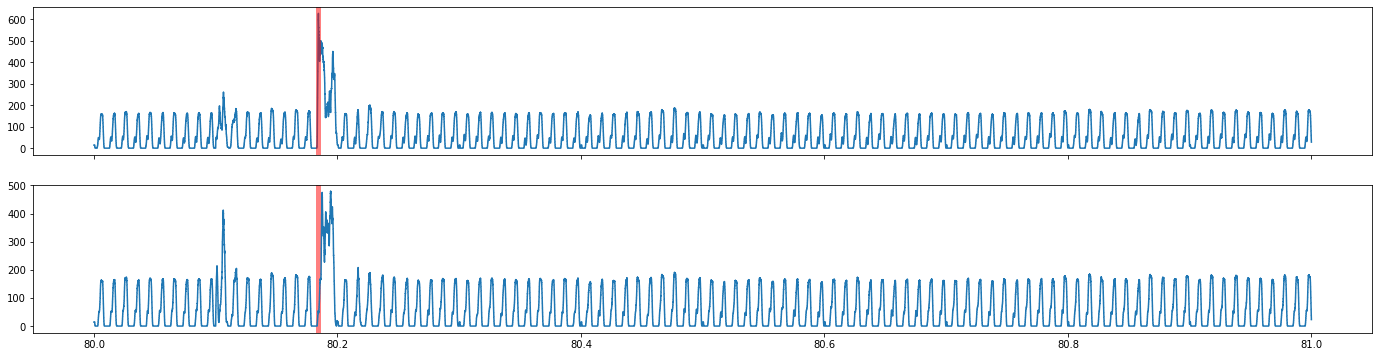

In [ ]:
f, (a1, a2) = plt.subplots(2, 1, sharex=True, figsize=(24,6))
a1.plot(t1, orig)
a1.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.plot(t1, shif)

(80.3, 80.7)

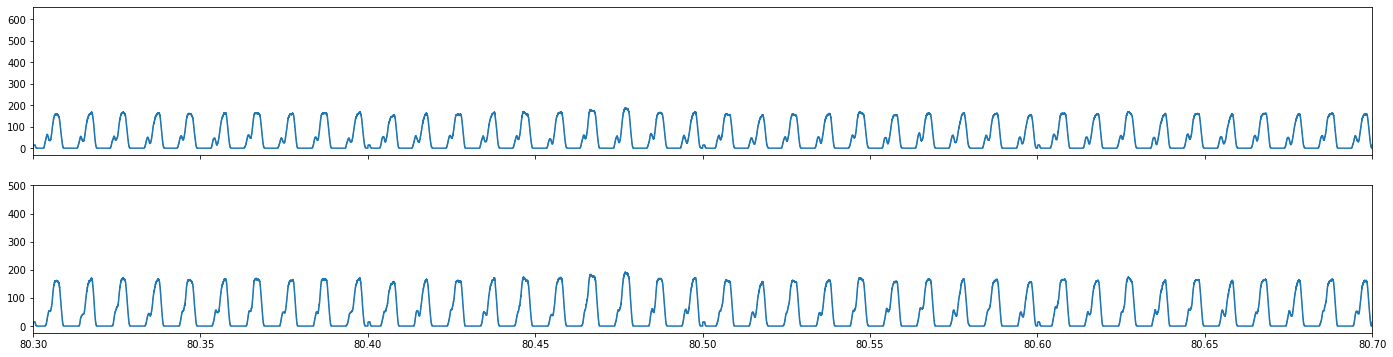

In [ ]:
f, (a1, a2) = plt.subplots(2, 1, sharex=True, figsize=(24,6))
a1.plot(t1, orig)
a1.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.plot(t1, shif)
a1.set_xlim(t1[0] + 0.3, t1[0] + 0.7)
# a2.set_ylim(t1[0] + 0.3, t1[0] + 0.7)

20 m => 13 ms, take 15ms matching buffer

In [ ]:
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)

In [ ]:
match_win = slice(index - buf_match, index + ping + buf)
corr_win = slice(index - buf, index + ping + buf)

Text(0.5, 0.98, 'Before Correlation Shift')

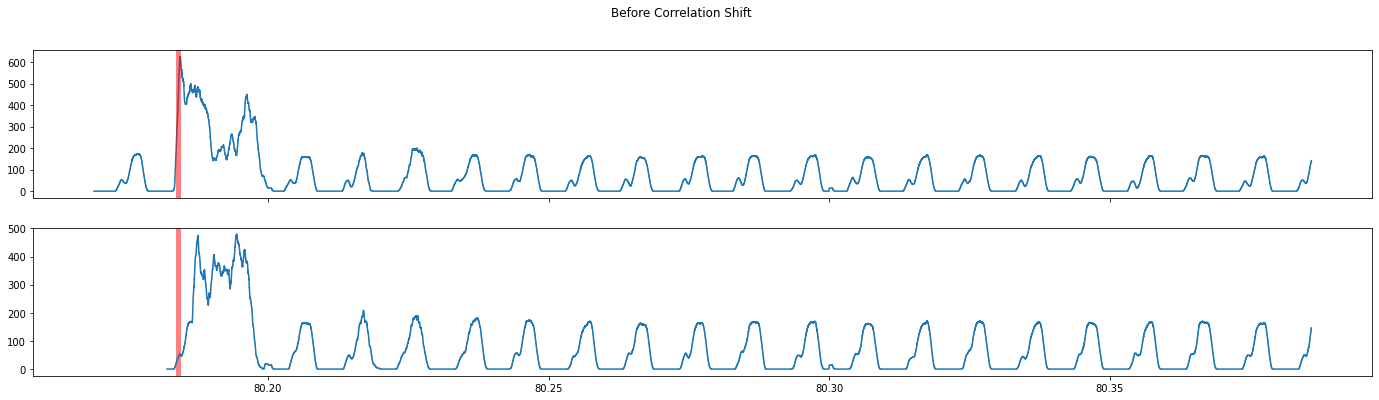

In [ ]:
f, (a1, a2) = plt.subplots(2, 1, sharex=True, figsize=(24,6))
a1.plot(t1[match_win], orig[match_win])
a1.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.plot(t1[corr_win], shif[corr_win])
f.suptitle("Before Correlation Shift")

In [ ]:
corr = np.convolve(orig[match_win], shif[corr_win][::-1] / 1.0, mode='valid') /3000 / 3000

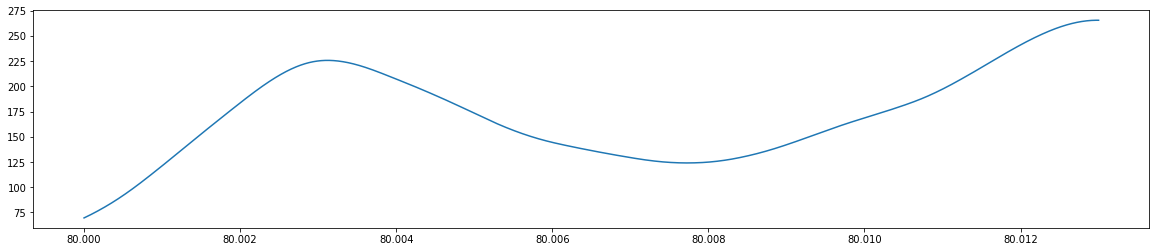

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(t1[:orig[match_win].shape[0] - shif[corr_win].shape[0] + 1], corr)

In [ ]:
shift = (buf_match - buf -  np.argmax(corr)) * dt
shift * 1000, "ms"

(0.023, 'ms')

In [ ]:
shift * 1500

0.0345

Text(0.5, 0.98, 'Before Correlation Shift')

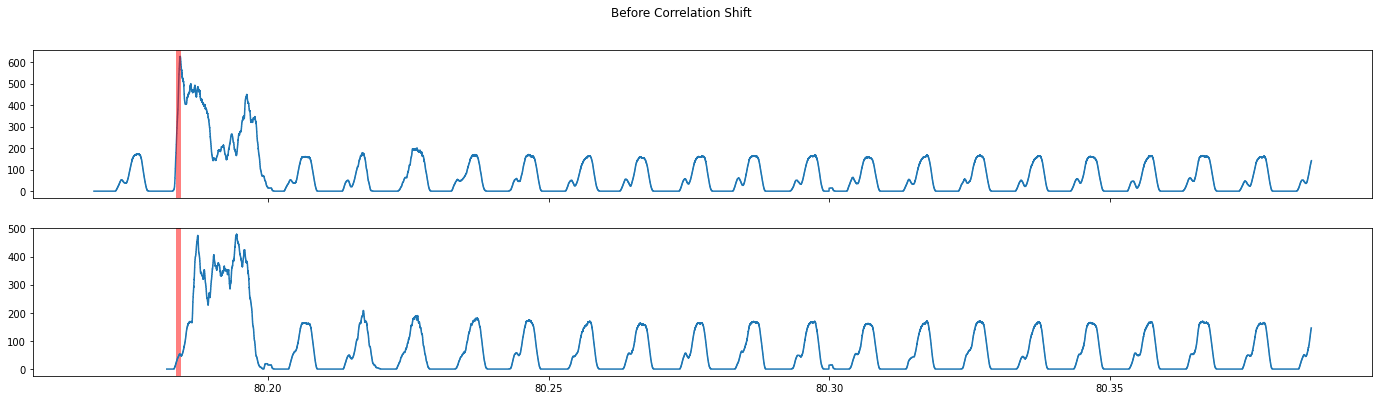

In [ ]:
f, (a1, a2) = plt.subplots(2, 1, sharex=True, figsize=(24,6))
a1.plot(t1[match_win], orig[match_win])
a1.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.axvline(x=t1[0]+index * dt, color='red', linewidth=5, alpha=0.5)
a2.plot(t1[corr_win] - shift, shif[corr_win])
f.suptitle("Before Correlation Shift")

zz## Correlation TDOA

In [ ]:
t_start = 20
t1 = t[int(fs * t_start):int(fs * (t_start + 1))]
y1 = y[int(fs * t_start):int(fs * (t_start + 1))]

In [ ]:
orig = y1[:, 0]
shif = y1[:, 1:5]

In [ ]:
index = Est_ZC_stage_1(orig, int(0.004 * fs), 100, run_plot=False)
if index == 0:
    raise IndexError()

In [ ]:
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)

match_win = slice(index - buf_match, index + ping + buf)
corr_win = slice(index - buf, index + ping + buf)

In [ ]:
shifts = np.array([buf_match - buf - np.argmax(np.convolve(orig[match_win], row[corr_win][::-1] / 1.0, mode='valid') /3000 / 3000) for row in shif.T]) * dt
shifts * 1000

array([0.146, 0.147, 0.067, 0.   ])

In [ ]:
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))

In [ ]:
dists = shifts * 1480
dists

array([0.21608, 0.21756, 0.09916, 0.     ])

In [ ]:
dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
while np.any(np.isnan(dists_2d)):
    dists += 0.1
    dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
dists_2d = np.nan_to_num(dists_2d, 0)
dists_2d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


array([0.54929643, 2.19284846, 2.19688523, 1.6874537 ])

In [ ]:
from scipy.optimize import minimize

In [ ]:
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

# Initial guess is weighted average (by distance) of station coordinates
x0 = (h_locs[:, :2] + dists_2d[:, None]).sum(axis=0) / np.sum(dists_2d)

# optimize distance from signal origin to border of spheres
loc = minimize(error, x0, args=(h_locs[:, :2], dists_2d), method='Nelder-Mead').x
loc

array([4.34159206, 1.1437602 ])

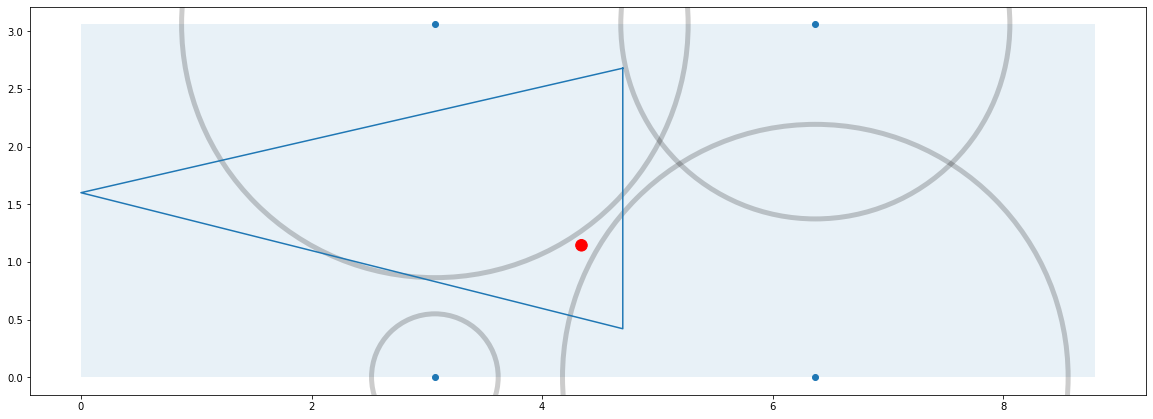

In [ ]:
f, ax = plt.subplots(1,1, figsize=(20,10))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(*ax.get_ylim())

for hp, d2d in zip(h_locs, dists_2d):
    ax.add_patch(mp_patches.Circle(hp[:2], d2d, fill=False, alpha=0.2, linewidth=5))

ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))


In [ ]:
dists

array([2.31608, 2.31756, 2.19916, 2.1    ])

In [ ]:
dists_2d

array([0.54929643, 2.19284846, 2.19688523, 1.6874537 ])

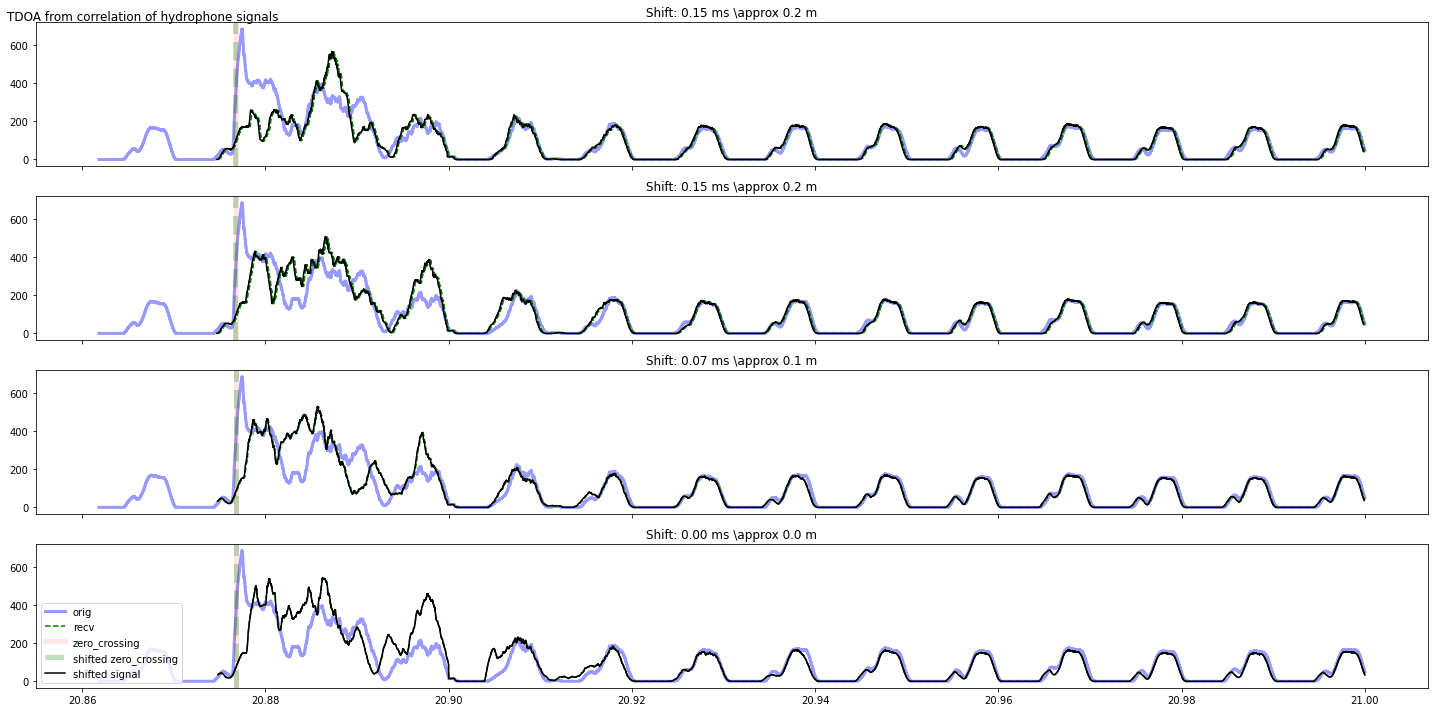

In [ ]:
f, axs = plt.subplots(shif.shape[1], 1, sharex=True, sharey=True, figsize=(20,10))
for ax, col, sh in zip(axs, shif.T, shifts):
    ax.plot(t1[match_win], orig[match_win], alpha=0.4, linewidth=3, color='blue', label='orig')
    ax.plot(t1[corr_win], col[corr_win], '--', color='green', label='recv')
    ax.axvline(x=t1[0] + index * dt, color='red', linewidth=5, alpha=0.1, label='zero_crossing')
    ax.axvline(x=t1[0] + index * dt - sh, linestyle='--', color='green', linewidth=5, alpha=0.25, label='shifted zero_crossing')
    ax.plot(t1[corr_win] - sh, col[corr_win], 'black', label='shifted signal')
    ax.set_title(fr'Shift: {sh*1000:.2f} ms \approx {sh * 1500:.1f} m')
plt.legend(loc='lower left')
f.suptitle("TDOA from correlation of hydrophone signals", x=0.1)
f.tight_layout()
plt.show()

# Find Positions

## Correlation TDOA to position

In [ ]:
locs = []


from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))


for i in range(230):
    try:
        t_start = i
        win = slice(int(fs * t_start), int(fs * (t_start + 1)))
        t1 = t[win]
        orig = y[win, 0]
        shif = y[win, 1:5]
        index = Est_ZC_stage_1(orig, int(0.004 * fs), 100, run_plot=False)
        if index == 0:
            raise IndexError()

        match_win = slice(index - buf_match, index + ping + buf)
        corr_win = slice(index - buf, index + ping + buf)

        # print(shif.shape)
        shifts = np.array([buf_match - buf - np.argmax(np.convolve(orig[match_win], row[corr_win][::-1] / 1.0, mode='valid') /3000 / 3000) for row in shif.T]) * dt

        dists = shifts * 1480
        dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
        while np.any(np.isnan(dists_2d)):
            dists += 0.1
            dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)

        # Initial guess is weighted average (by distance) of station coordinates
        x0 = (h_locs[:, :2] + dists_2d[:, None]).sum(axis=0) / np.sum(dists_2d)

        # optimize distance from signal origin to border of spheres
        loc = minimize(error, x0, args=(h_locs[:, :2], dists_2d), method='Nelder-Mead').x
        locs.append(loc)  
    except Exception as e:
        print("Except:", e)                                                  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt


Except: 
Except: 
Except: 
Except: v cannot be empty
Except: 
Except: 
Except: 
Except: 
Except: 
Except: 
Except: 
Except: a cannot be empty
Except: v cannot be empty
Except: 
Except: 
Except: a cannot be empty
Except: 
Except: v cannot be empty


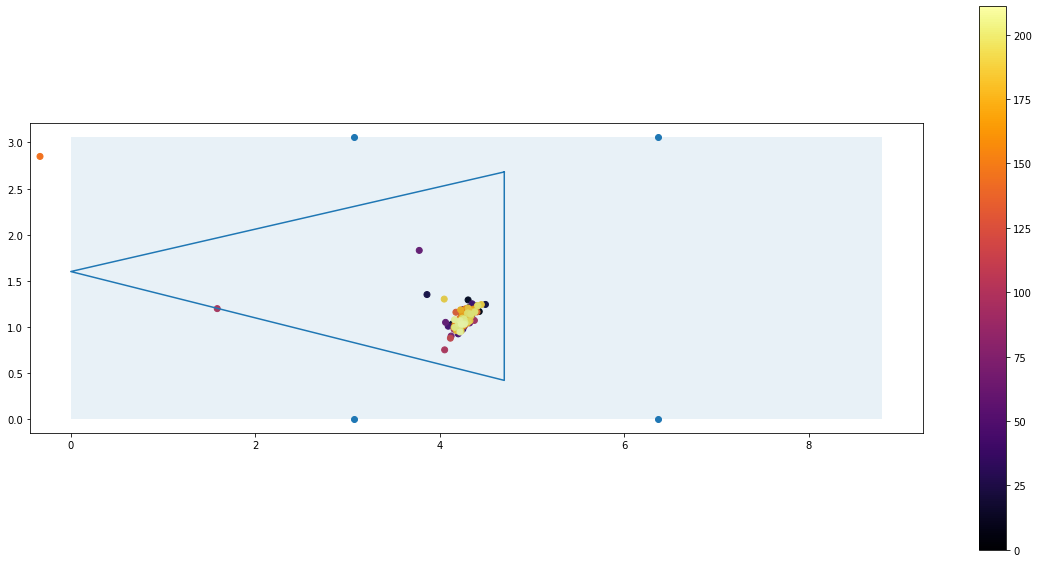

In [ ]:
f, ax = plt.subplots(1,1, figsize=(20,10))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(*ax.get_ylim())

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))


plt.scatter(*np.vstack(locs).T, c=np.arange(len(locs)), cmap='inferno')
plt.colorbar()

With basic filtering

In [ ]:
la = [a.copy() for a in locs]

In [ ]:
pos = np.array((4.6, 1.5))
i = 0
while i < len(la):
    if np.linalg.norm(la[i] - pos) <  1:
        pos = la[i]
        i += 1
    else:
        del la[i]

In [ ]:
print(len(locs), len(la))

212 157


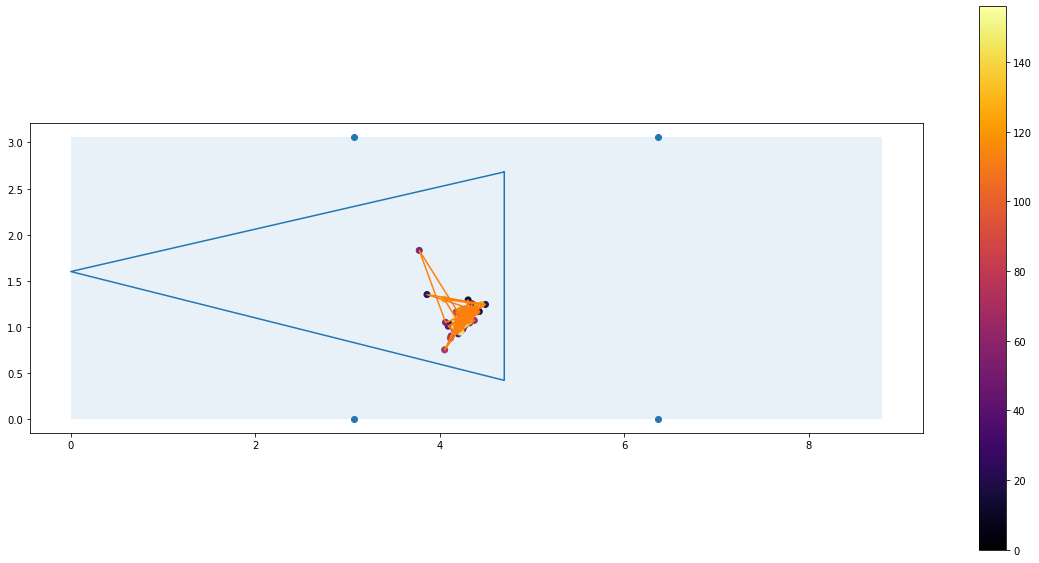

In [ ]:
f, ax = plt.subplots(1,1, figsize=(20,10))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(*ax.get_ylim())

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))

plt.plot(*np.vstack(la).T)
plt.scatter(*np.vstack(la).T, c=np.arange(len(la)), cmap='inferno')
plt.colorbar()

## Zero Crossing TDOA to position

In [ ]:
from tqdm.notebook import trange

In [ ]:
locs_t = []
locs_zc = []


from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))
v_sound = 1480

for i in trange(int(t[-1])):
    try:
        t_start = i
        win = slice(int(fs * t_start), int(fs * (t_start + 1)))
        t1 = t[win]
        index = Est_ZC_stage_1(y[win, 0], int(0.004 * fs), 100, run_plot=False)
        if index == 0:
            raise IndexError()

        indices = [
            Est_ZC_stage_1(ch, int(0.004 * fs), 100, run_plot=False)
            for ch in y[win,: ].T
        ]
        # print(indices)
        # indices = Est_ZC_stage_1(data, window_size, fs, multiplier)
        if 0 in indices:
            print("fail")
            continue

        zero_index = indices[0]
        dists = np.array([(index - zero_index) * v_sound / fs for index in indices[1:]])

        dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
        while np.any(np.isnan(dists_2d)):
            dists += 0.1
            dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)


        # Initial guess is weighted average (by distance) of station coordinates
        x0 = (h_locs[:, :2] + dists_2d[:, None]).sum(axis=0) / np.sum(dists_2d)

        # optimize distance from signal origin to border of spheres
        loc = minimize(error, x0, args=(h_locs[:, :2], dists_2d), method='Nelder-Mead').x

        locs_t.append(t_start + zero_index * dt)
        locs_zc.append(loc)  
    except Exception as e:
        print("Except:", e)                                                  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


fail
Except: 
fail
Except: 
Except: 
fail
fail
fail
Except: 
Except: 
Except: 
Except: 
Except: 
fail
Except: 
fail
Except: 
fail
fail
fail
Except: 
Except: 
Except: 
fail
fail
fail
fail
fail
fail
fail
fail


In [ ]:
locs_ta = [a.copy() for a in locs_t]
locs_zca = [a.copy() for a in locs_zc]

pos = np.array((4.6, 1.5))
i = 0
while i < len(locs_zca):
    if np.linalg.norm(locs_zca[i] - pos) <  4:
        pos = locs_zca[i]
        i += 1
    else:
        del locs_zca[i]
        del locs_ta[i]

In [ ]:
locs_taa = [a.copy() for a in locs_t]
locs_zcaa = [a.copy() for a in locs_zc]
pos = np.array((4.6, 1.5))
i = 0
while i < len(locs_zcaa):
    if (0 <= locs_zcaa[i][0] <= 8.8) and (0 <= locs_zcaa[i][1] <= 3.2) and np.linalg.norm(locs_zcaa[i] - pos) <  3:
        pos = locs_zcaa[i]
        i += 1
    else:
        del locs_zcaa[i]
        del locs_taa[i]

Text(0.5, 0.98, '')

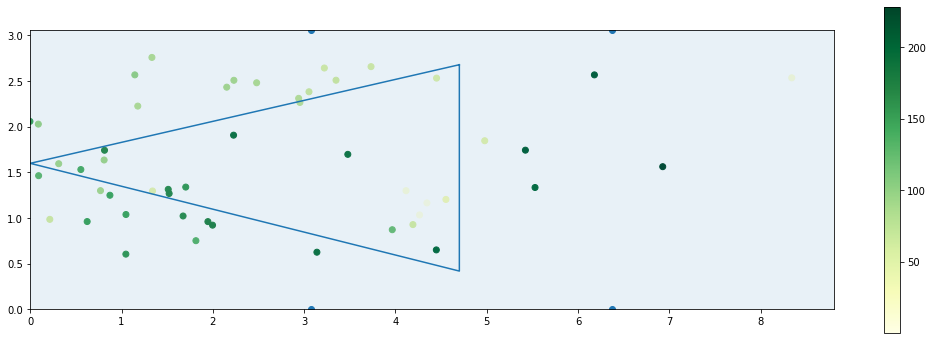

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(*ax.get_xlim())
# ax.set_ylim(*ax.get_ylim())

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))
# plt.plot(*np.vstack(locs_zca).T, alpha=0.5)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

Text(0.5, 0.98, '')

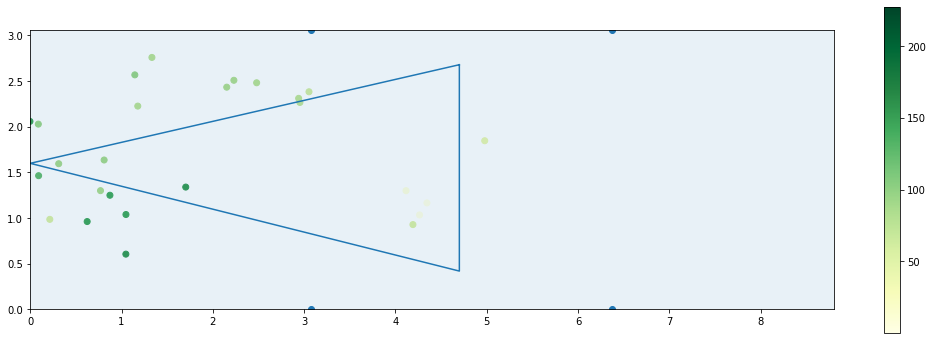

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(*ax.get_xlim())
# ax.set_ylim(*ax.get_ylim())

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))
# plt.plot(*np.vstack(locs_zca).T, alpha=0.5)

plt.scatter(*np.vstack(locs_zca).T, c=locs_ta, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

Text(0.5, 0.98, '')

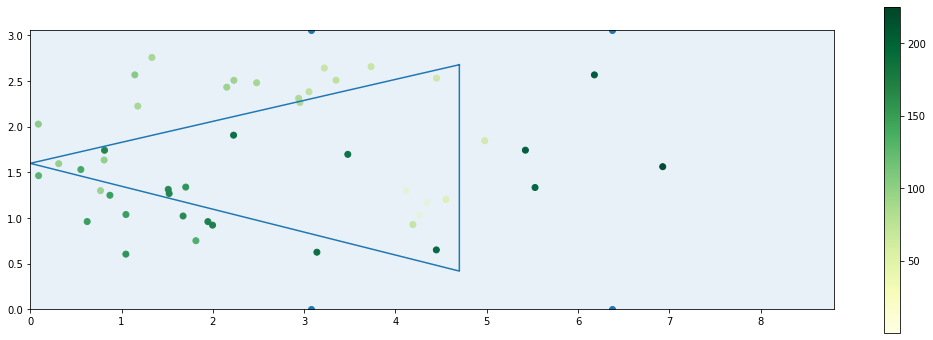

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(*ax.get_xlim())
# ax.set_ylim(*ax.get_ylim())

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))
# plt.plot(*np.vstack(locs_zca).T, alpha=0.5)

plt.scatter(*np.vstack(locs_zcaa).T, c=locs_taa, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

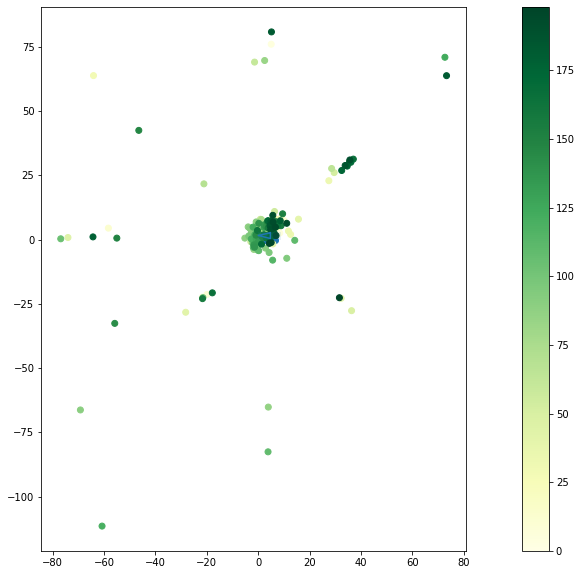

In [ ]:
f, ax = plt.subplots(1,1, figsize=(20,10))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(*ax.get_xlim())
# ax.set_ylim(*ax.get_ylim())

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))

plt.scatter(*np.vstack(locs_zc).T, c=np.arange(len(locs_zc)), cmap='YlGn')
plt.colorbar()

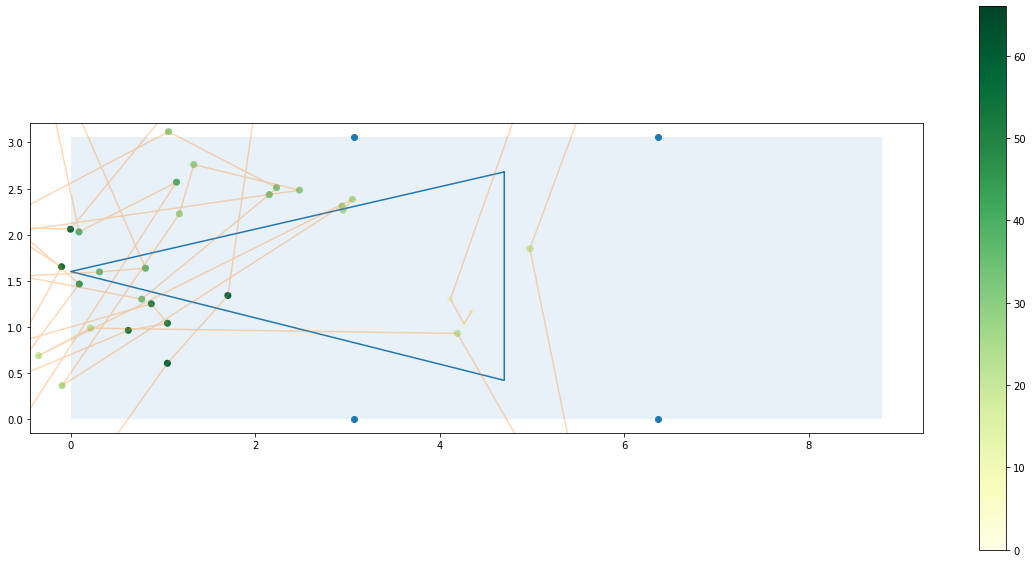

In [ ]:

f, ax = plt.subplots(1,1, figsize=(20,10))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(*ax.get_ylim())

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))

plt.scatter(*np.vstack(locs_zca).T, c=np.arange(len(locs_zca)), cmap='YlGn')

plt.plot(*np.vstack(locs_zca).T, alpha=0.3)
# plt.plot(*np.vstack(la).T)
plt.colorbar()

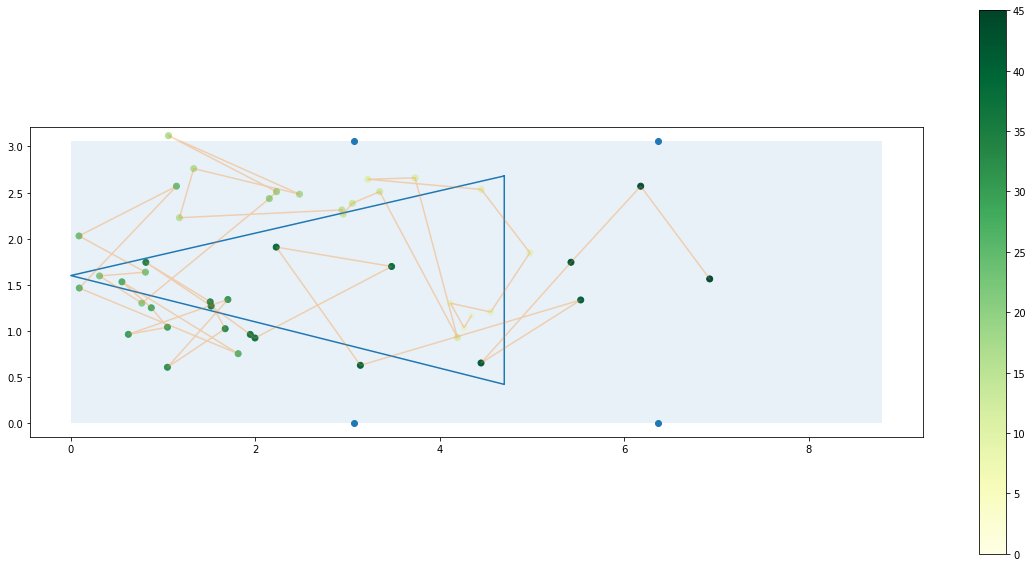

In [ ]:

f, ax = plt.subplots(1,1, figsize=(20,10))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(*ax.get_xlim())
ax.set_ylim(*ax.get_ylim())

# ax.add_patch(mp_patches.Circle(loc[:2], 0.05, fill=True, color='red'))

plt.scatter(*np.vstack(locs_zcaa).T, c=np.arange(len(locs_zcaa)), cmap='YlGn')

plt.plot(*np.vstack(locs_zcaa).T, alpha=0.3)
# plt.plot(*np.vstack(la).T)
plt.colorbar()

In [ ]:
position_data_zc = np.hstack((np.array(locs_t).reshape((-1, 1)), locs_zc))

In [ ]:
np.savetxt('position_data_zc.csv', position_data_zc, delimiter=', ', header='t, x, y')

## Find Ranges

In [ ]:
locs_t = []
locs_r = []
locs_zc = []


from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))
v_sound = 1480

for i in range(230):
    try:
        t_start = i
        win = slice(int(fs * t_start), int(fs * (t_start + 1)))
        t1 = t[win]
        index = Est_ZC_stage_1(y[win, 0], int(0.004 * fs), 100, run_plot=False)
        if index == 0:
            raise IndexError()

        indices = [
            Est_ZC_stage_1(ch, int(0.004 * fs), 100, run_plot=False)
            for ch in y[win,: ].T
        ]
        # print(indices)
        # indices = Est_ZC_stage_1(data, window_size, fs, multiplier)
        if 0 in indices:
            print("fail")
            continue

        zero_index = indices[0]
        dists = np.array([(index - zero_index) * v_sound / fs for index in indices[1:]])

        dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
        while np.any(np.isnan(dists_2d)):
            dists += 0.1
            dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)


        # Initial guess is weighted average (by distance) of station coordinates
        x0 = (h_locs[:, :2] + dists_2d[:, None]).sum(axis=0) / np.sum(dists_2d)

        # optimize distance from signal origin to border of spheres
        loc = minimize(error, x0, args=(h_locs[:, :2], dists_2d), method='Nelder-Mead').x

        locs_t.append(t_start + zero_index * dt)
        locs_r.append(dists_2d)
        locs_zc.append(loc)  
    except Exception as e:
        print("Except:", e)                                                  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


fail
Except: 
fail
Except: 
Except: 
fail
fail
fail
Except: 
Except: 
Except: 
Except: 
Except: 
fail
Except: 
fail
Except: 
fail
fail
fail
Except: 
Except: 
Except: 
fail
fail
fail
fail
fail
fail
fail
fail


In [ ]:
L = 8.8
W = 3.0
path = [4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))

f.suptitle('Raw Acoustic Positions')

ax.set_aspect('equal', 'box')
buf = 0.2
ax.set_xlim(0 - L * buf, L * (1 + buf))
ax.set_ylim(0 - W * buf, W * (1 + buf))

ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='gray', label='Pool'))
ax.plot(*zip(*path), color='red', label="Ground Truth")


cs = [
      ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
      for loc in h_locs
]

from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

prev = ax.add_patch(mp_patches.Ellipse((0,0), 0.1, 0.1, alpha=0.2, color='black'))
text = ax.text(0, 0, "time")
def anim_func(frame, ax, loc):
    # print(frame)
    global prev
    sc = ax.scatter(*prev.get_center(), color='red', s=0.2)
    prev.remove()

    d = locs_r[frame]
    text.set_text(f"{locs_t[frame]:.2f}\t{d[0]:.2f}\t{d[1]:.2f}\t{d[2]:.2f}\t{d[3]:.2f}")
    ret1 = ax.add_patch(mp_patches.Ellipse(locs_zc[frame], 0.2, 0.2, alpha=0.2, color='black'))
    for c, dist in zip(cs,locs_r[frame]) :
        c.set_radius(dist)
    prev = ret1
    return [sc, ret1, text] + cs 

anim = FuncAnimation(f, anim_func, fargs=(ax, None), 
                     frames=len(locs_r), interval=5)#, blit=True)

plt.close()

In [ ]:
anim

## Voting Based

In [ ]:
from tqdm.notebook import trange

from itertools import combinations

In [ ]:
y[win, 1: ].T[0].shape, y[win, 0].shape

((1000000,), (1000000,))

In [ ]:
dists

array([  3.22784,  -4.21804, 137.66364,   1.29496])

In [ ]:
dists[[0,2]]

array([  3.22784, 137.66364])

In [ ]:
next(combinations(range(4), 3))

(0, 1, 2)

In [ ]:
locs_t = []
locs_r = []
locs_zc = []


from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))
v_sound = 1480

for i in trange(int(t[-1])):
    try:
        t_start = i
        win = slice(int(fs * t_start), int(fs * (t_start + 1)))
        t1 = t[win]

        zero_index = Est_ZC_stage_1(y[win, 0], int(0.004 * fs), 100, run_plot=False)
        if zero_index == 0:
            continue;

        indices = [
            Est_ZC_stage_1(ch, int(0.004 * fs), 100, run_plot=False)
            for ch in y[win, 1: ].T
        ]

        if 0 in indices:
            continue

        dists = np.array([(index - zero_index) * v_sound / fs for index in indices])

        dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
        while np.any(np.isnan(dists_2d)):  # TODO: Remove
            dists += 0.1
            dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)

        min_err = float('inf')
        best_loc = None
        for inds in combinations(range(4), 3):
            inds=list(inds)
            # Initial guess is weighted average (by distance) of station coordinates
            hl = h_locs[inds, :]
            ds = dists_2d[inds]

            x0 = (hl[:, :2] + ds[:, None]).sum(axis=0) / np.sum(ds)

            # optimize distance from signal origin to border of spheres
            loc = minimize(error, x0, args=(hl[:, :2], ds), method='Nelder-Mead').x
            err = error(loc, hl[:, :2], ds)
            if err < min_err:
            
                min_err = err
                best_loc = loc

        locs_t.append(t_start + zero_index * dt)
        locs_r.append(dists_2d)
        locs_zc.append(best_loc)  
    except ValueError as e: #Exception as e:
        print("Except:", e)                                                  

  0%|          | 0/239 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
L = 8.8
W = 3.0
path = [4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]

Text(0.5, 0.98, '')

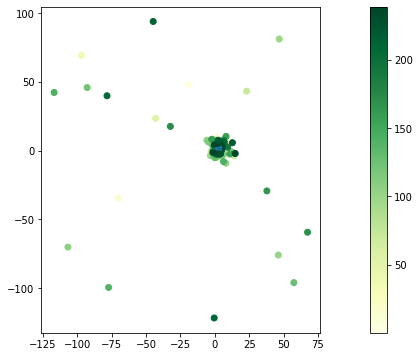

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(0, 8.8)
# ax.set_ylim(0, 3.06)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

Text(0.5, 0.98, '')

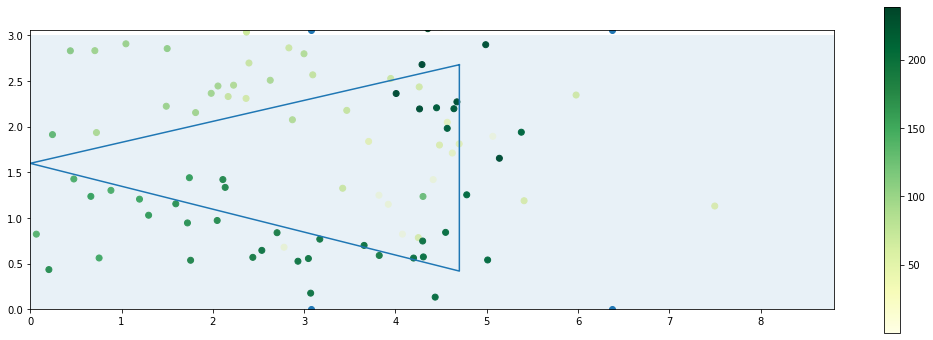

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))

f.suptitle('Raw Acoustic Positions')

ax.set_aspect('equal', 'box')
buf = 0.2
ax.set_xlim(0 - L * buf, L * (1 + buf))
ax.set_ylim(0 - W * buf, W * (1 + buf))

ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='gray', label='Pool'))
ax.plot(*zip(*path), color='red', label="Ground Truth")


cs = [
      ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
      for loc in h_locs
]

from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

prev = ax.add_patch(mp_patches.Ellipse((0,0), 0.1, 0.1, alpha=0.2, color='black'))
text = ax.text(0, 0, "time")
def anim_func(frame, ax, loc):
    # print(frame)
    global prev
    sc = ax.scatter(*prev.get_center(), color='red', s=0.2)
    prev.remove()

    d = locs_r[frame]
    text.set_text(f"{locs_t[frame]:.2f}\t{d[0]:.2f}\t{d[1]:.2f}\t{d[2]:.2f}\t{d[3]:.2f}")
    ret1 = ax.add_patch(mp_patches.Ellipse(locs_zc[frame], 0.2, 0.2, alpha=0.2, color='black'))
    for c, dist in zip(cs,locs_r[frame]) :
        c.set_radius(dist)
    prev = ret1
    return [sc, ret1, text] + cs 

anim = FuncAnimation(f, anim_func, fargs=(ax, None), 
                     frames=len(locs_r), interval=5)#, blit=True)

plt.close()

In [ ]:
anim

## Voting Based ignore nans

In [ ]:
from tqdm.notebook import trange

from itertools import combinations

In [ ]:
locs_t = []
locs_r = []
locs_zc = []

from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))
v_sound = 1480

for i in trange(int(t[-1])):
    try:
        t_start = i
        win = slice(int(fs * t_start), int(fs * (t_start + 1)))
        t1 = t[win]

        zero_index = Est_ZC_stage_1(y[win, 0], int(0.004 * fs), 100, run_plot=False)
        if zero_index == 0:
            continue;

        indices = [
            Est_ZC_stage_1(ch, int(0.004 * fs), 100, run_plot=False)
            for ch in y[win, 1: ].T
        ]

        if 0 in indices:
            continue

        dists = np.array([(index - zero_index) * v_sound / fs for index in indices])

        dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
        
        min_err = float('inf')
        best_loc = None
        for inds in combinations(np.where(np.isfinite(dists_2d))[0], 3):
            inds=list(inds)
            # Initial guess is weighted average (by distance) of station coordinates
            hl = h_locs[inds, :]
            ds = dists_2d[inds]

            x0 = (hl[:, :2] + ds[:, None]).sum(axis=0) / np.sum(ds)

            # optimize distance from signal origin to border of spheres
            loc = minimize(error, x0, args=(hl[:, :2], ds), method='Nelder-Mead').x
            err = error(loc, hl[:, :2], ds)
            if err < min_err:
            
                min_err = err
                best_loc = loc
        if best_loc is None:
            continue
        locs_t.append(t_start + zero_index * dt)
        locs_r.append(dists_2d)
        locs_zc.append(best_loc)  
    except ValueError as e: #Exception as e:
        print("Except:", e)                                                  
print(len(locs_t))

  0%|          | 0/239 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt


199


In [ ]:
L = 8.8
W = 3.0
path = [4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]

Text(0.5, 0.98, '')

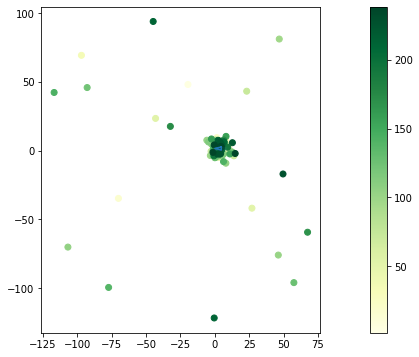

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(0, 8.8)
# ax.set_ylim(0, 3.06)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

Text(0.5, 0.98, '')

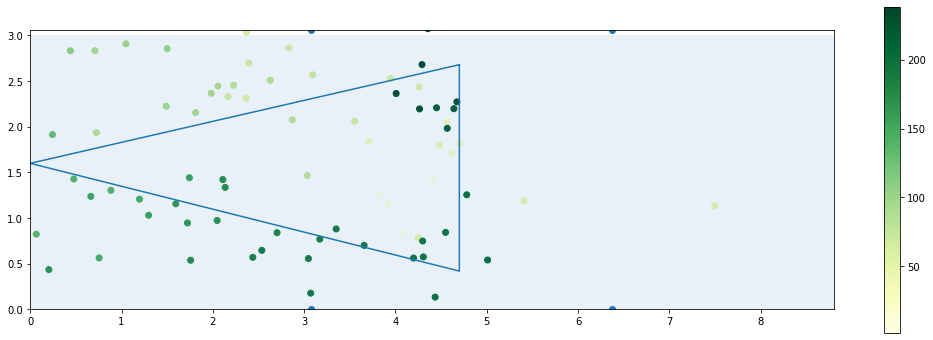

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))

f.suptitle('Raw Acoustic Positions')

ax.set_aspect('equal', 'box')
buf = 0.2
ax.set_xlim(0 - L * buf, L * (1 + buf))
ax.set_ylim(0 - W * buf, W * (1 + buf))

ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='gray', label='Pool'))
ax.plot(*zip(*path), color='red', label="Ground Truth")


cs = [
      ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
      for loc in h_locs
]

from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

prev = ax.add_patch(mp_patches.Ellipse((0,0), 0.1, 0.1, alpha=0.2, color='black'))
text = ax.text(0, 0, "time")
def anim_func(frame, ax, loc):
    # print(frame)
    global prev
    sc = ax.scatter(*prev.get_center(), color='red', s=0.2)
    prev.remove()

    d = locs_r[frame]
    text.set_text(f"{locs_t[frame]:.2f}\t{d[0]:.2f}\t{d[1]:.2f}\t{d[2]:.2f}\t{d[3]:.2f}")
    ret1 = ax.add_patch(mp_patches.Ellipse(locs_zc[frame], 0.2, 0.2, alpha=0.2, color='black'))
    for c, dist in zip(cs,locs_r[frame]) :
        c.set_radius(dist)
    prev = ret1
    return [sc, ret1, text] + cs 

anim = FuncAnimation(f, anim_func, fargs=(ax, None), 
                     frames=len(locs_r), interval=5)#, blit=True)

plt.close()

In [ ]:
anim

## Voting Based ignore nans + bounds check

In [ ]:
from tqdm.notebook import trange

from itertools import combinations

In [ ]:
L = 8.8
W = 3.0
path = [4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]

In [ ]:
locs_t = []
locs_r = []
locs_zc = []

from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))
v_sound = 1480

for i in trange(int(t[-1])):
    try:
        t_start = i
        win = slice(int(fs * t_start), int(fs * (t_start + 1)))
        t1 = t[win]

        zero_index = Est_ZC_stage_1(y[win, 0], int(0.004 * fs), 100, run_plot=False)
        if zero_index == 0:
            continue;

        indices = [
            Est_ZC_stage_1(ch, int(0.004 * fs), 100, run_plot=False)
            for ch in y[win, 1: ].T
        ]

        if 0 in indices:
            continue

        dists = np.array([(index - zero_index) * v_sound / fs for index in indices])

        dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
        
        min_err = float('inf')
        best_loc = None
        for inds in combinations(np.where(np.isfinite(dists_2d))[0], 3):
            inds=list(inds)
            # Initial guess is weighted average (by distance) of station coordinates
            hl = h_locs[inds, :]
            ds = dists_2d[inds]

            x0 = (hl[:, :2] + ds[:, None]).sum(axis=0) / np.sum(ds)

            # optimize distance from signal origin to border of spheres
            loc = minimize(error, x0, args=(hl[:, :2], ds), method='Nelder-Mead').x
            xxx, yyy = loc
            if (0 < xxx < L) and (0 < yyy < W):    
                err = error(loc, hl[:, :2], ds)
                if err < min_err:
                    min_err = err
                    best_loc = loc
        if best_loc is None:
            continue

        locs_t.append(t_start + zero_index * dt)
        locs_r.append(dists_2d)
        locs_zc.append(best_loc)  
    except ValueError as e: #Exception as e:
        print("Except:", e)                                                  
print(len(locs_t))

  0%|          | 0/239 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt


94


Text(0.5, 0.98, '')

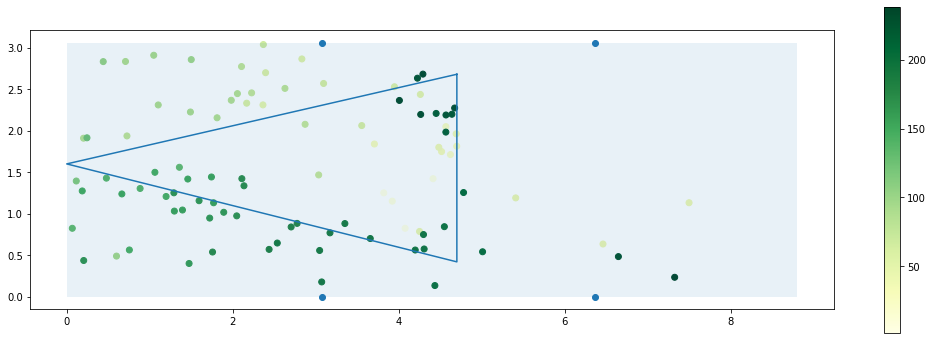

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(0, 8.8)
# ax.set_ylim(0, 3.06)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

Text(0.5, 0.98, '')

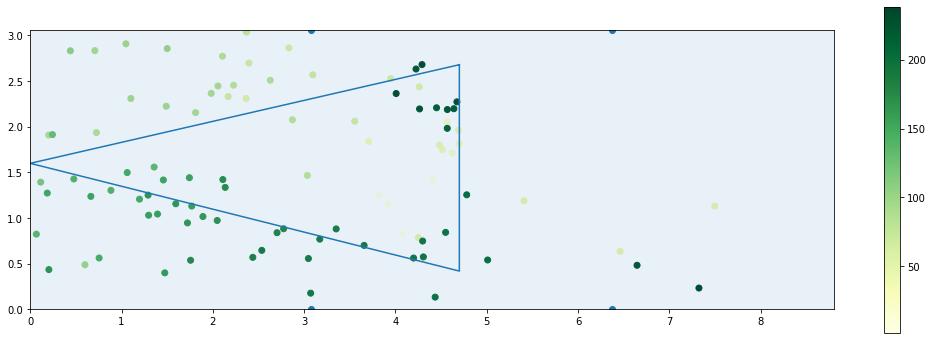

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(0, 8.8)
ax.set_ylim(0, 3.06)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))

f.suptitle('Raw Acoustic Positions')

ax.set_aspect('equal', 'box')
buf = 0.2
ax.set_xlim(0 - L * buf, L * (1 + buf))
ax.set_ylim(0 - W * buf, W * (1 + buf))

ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='gray', label='Pool'))
ax.plot(*zip(*path), color='red', label="Ground Truth")


cs = [
      ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
      for loc in h_locs
]

from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

prev = ax.add_patch(mp_patches.Ellipse((0,0), 0.1, 0.1, alpha=0.2, color='black'))
text = ax.text(0, 0, "time")
def anim_func(frame, ax, loc):
    # print(frame)
    global prev
    sc = ax.scatter(*prev.get_center(), color='red', s=0.2)
    prev.remove()

    d = locs_r[frame]
    text.set_text(f"{locs_t[frame]:.2f}\t{d[0]:.2f}\t{d[1]:.2f}\t{d[2]:.2f}\t{d[3]:.2f}")
    ret1 = ax.add_patch(mp_patches.Ellipse(locs_zc[frame], 0.2, 0.2, alpha=0.2, color='black'))
    for c, dist in zip(cs,locs_r[frame]):
        c.set_radius(dist)
    prev = ret1
    return [sc, ret1, text] + cs 

anim = FuncAnimation(f, anim_func, fargs=(ax, None), 
                     frames=len(locs_r), interval=5)#, blit=True)

plt.close()

In [ ]:
anim

## Voting Based ignore nans + bounds check + all 4

In [ ]:
from tqdm.notebook import trange
from itertools import combinations, chain

In [ ]:
L = 8.8
W = 3.0
path = [4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]

In [ ]:
locs_t = []
locs_r = []
locs_zc = []

from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)
buf_match = int(15e-3 * fs)
ping = int(200e-3 * fs)
buf = int(2e-3 * fs)
L, W = 8.8, 3.06
h_locs = np.array((
    (3.07, 0.00, -2.50),
    (6.37, 0.00, -1.00),
    (3.07, 3.06, -0.15),
    (6.37, 3.06, -1.50)
))
v_sound = 1480

for i in trange(int(t[-1])):
    try:
        t_start = i
        win = slice(int(fs * t_start), int(fs * (t_start + 1)))
        t1 = t[win]

        zero_index = Est_ZC_stage_1(y[win, 0], int(0.004 * fs), 100, run_plot=False)
        if zero_index == 0:
            continue;

        indices = [
            Est_ZC_stage_1(ch, int(0.004 * fs), 100, run_plot=False)
            for ch in y[win, 1: ].T
        ]

        if 0 in indices:
            continue

        dists = np.array([(index - zero_index) * v_sound / fs for index in indices])

        dists_2d = np.sqrt(dists**2 - (h_locs[:, 2] + 0.25)**2)
        
        min_err = float('inf')
        best_loc = None
        inds_list = combinations(np.where(np.isfinite(dists_2d))[0], 3)
        if np.all(np.isfinite(dists_2d)):
            inds_list = chain(inds_list, [(0,1,2,3),])
        for inds in inds_list:
            inds=list(inds)
            # Initial guess is weighted average (by distance) of station coordinates
            hl = h_locs[inds, :]
            ds = dists_2d[inds]

            x0 = (hl[:, :2] + ds[:, None]).sum(axis=0) / np.sum(ds)

            # optimize distance from signal origin to border of spheres
            loc = minimize(error, x0, args=(hl[:, :2], ds), method='Nelder-Mead').x
            xxx, yyy = loc
            if (0 < xxx < L) and (0 < yyy < W):    
                err = error(loc, hl[:, :2], ds) / len(ds)
                if err < min_err:
                    min_err = err
                    best_loc = loc
        if best_loc is None:
            continue

        locs_t.append(t_start + zero_index * dt)
        locs_r.append(dists_2d)
        locs_zc.append(best_loc)  
    except ValueError as e: #Exception as e:
        print("Except:", e)                                                  
print(len(locs_t))

  0%|          | 0/239 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt


95


Text(0.5, 0.98, '')

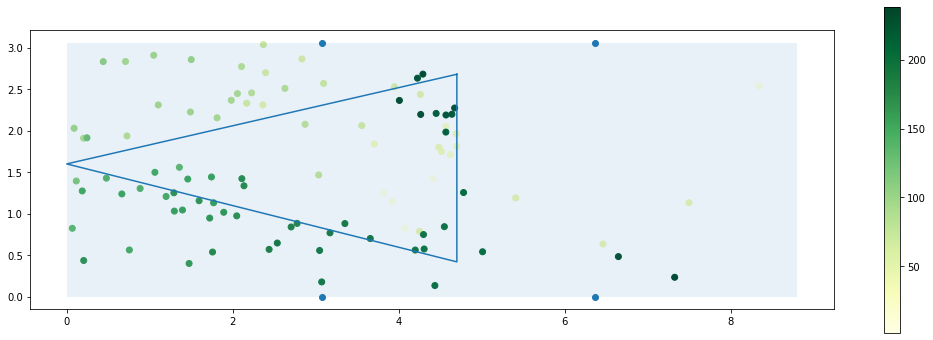

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

# ax.set_xlim(0, 8.8)
# ax.set_ylim(0, 3.06)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

Text(0.5, 0.98, '')

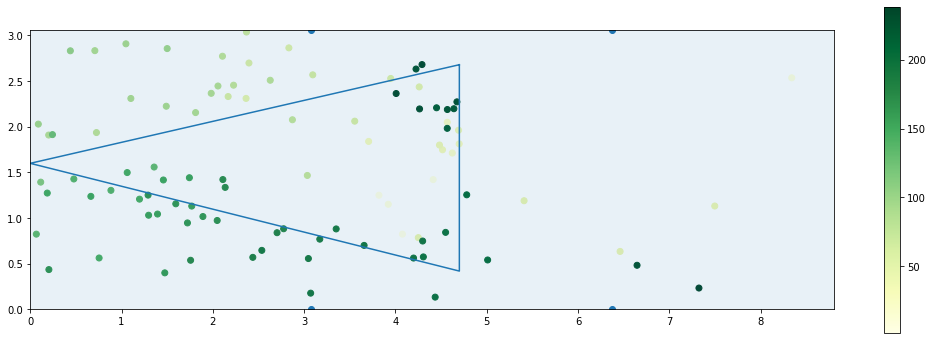

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))
# ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(0, L)
ax.set_ylim(0, W)

plt.scatter(*np.vstack(locs_zc).T, c=locs_t, cmap='YlGn')
plt.colorbar()
plt.suptitle('')

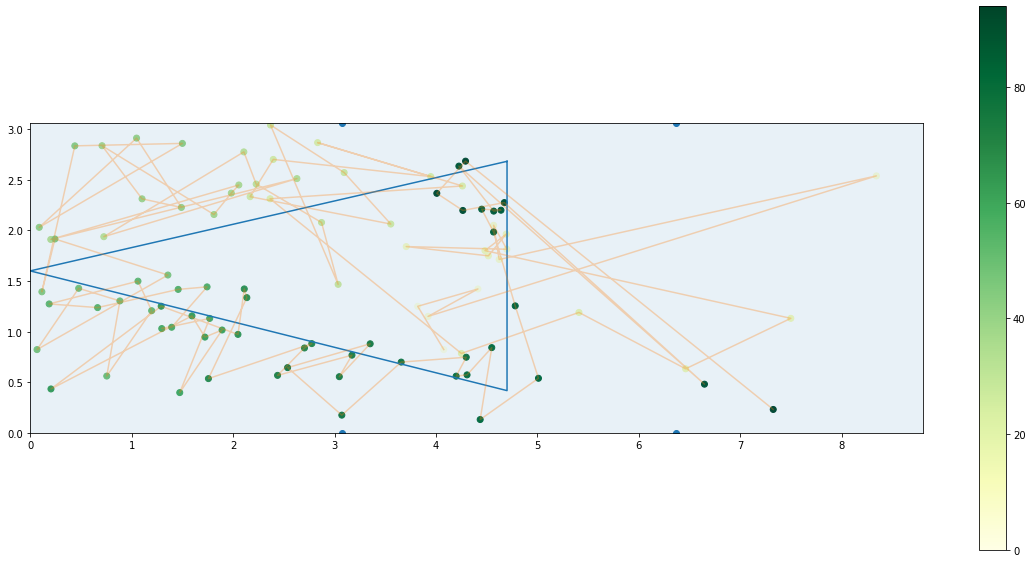

In [ ]:
f, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_aspect('equal', 'box')

ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1))
ax.scatter(h_locs[:, 0], h_locs[:, 1])
ax.plot(*zip([4.7, 2.68], [0, 1.6], [4.7, 0.42], [4.7, 2.68]), label="Ground Truth")

ax.set_xlim(0, L)
ax.set_ylim(0, W)

plt.scatter(*np.vstack(locs_zc).T, c=np.arange(len(locs_zc)), cmap='YlGn')

plt.plot(*np.vstack(locs_zc).T, alpha=0.3)

plt.colorbar()

In [ ]:
f, ax = plt.subplots(1,1, figsize=(18,6))

f.suptitle('Raw Acoustic Positions')

ax.set_aspect('equal', 'box')
buf = 0.2
ax.set_xlim(0 - L * buf, L * (1 + buf))
ax.set_ylim(0 - W * buf, W * (1 + buf))

ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='gray', label='Pool'))
ax.plot(*zip(*path), color='red', label="Ground Truth")


cs = [
      ax.add_patch(mp_patches.Circle(loc[:2], 0, fill=False, alpha=0.2, linewidth=5))
      for loc in h_locs
]

from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

prev = ax.add_patch(mp_patches.Ellipse((0,0), 0.1, 0.1, alpha=0.2, color='black'))
text = ax.text(0, 0, "time")
def anim_func(frame, ax, loc):
    # print(frame)
    global prev
    sc = ax.scatter(*prev.get_center(), color='red', s=0.2)
    prev.remove()

    d = locs_r[frame]
    text.set_text(f"{locs_t[frame]:.2f}\t{d[0]:.2f}\t{d[1]:.2f}\t{d[2]:.2f}\t{d[3]:.2f}")
    ret1 = ax.add_patch(mp_patches.Ellipse(locs_zc[frame], 0.2, 0.2, alpha=0.2, color='black'))
    for c, dist in zip(cs,locs_r[frame]) :
        c.set_radius(dist)
    prev = ret1
    return [sc, ret1, text] + cs 

anim = FuncAnimation(f, anim_func, fargs=(ax, None), 
                     frames=len(locs_r), interval=5)#, blit=True)

plt.close()

In [ ]:
anim

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


In [ ]:
position_data_zc = np.hstack((np.array(locs_t).reshape((-1, 1)), locs_zc))

In [ ]:
np.savetxt('position_data_zc.csv', position_data_zc, delimiter=', ', header='t, x, y')

# Full Data Length ZC Analysis

## Full ZC Plot

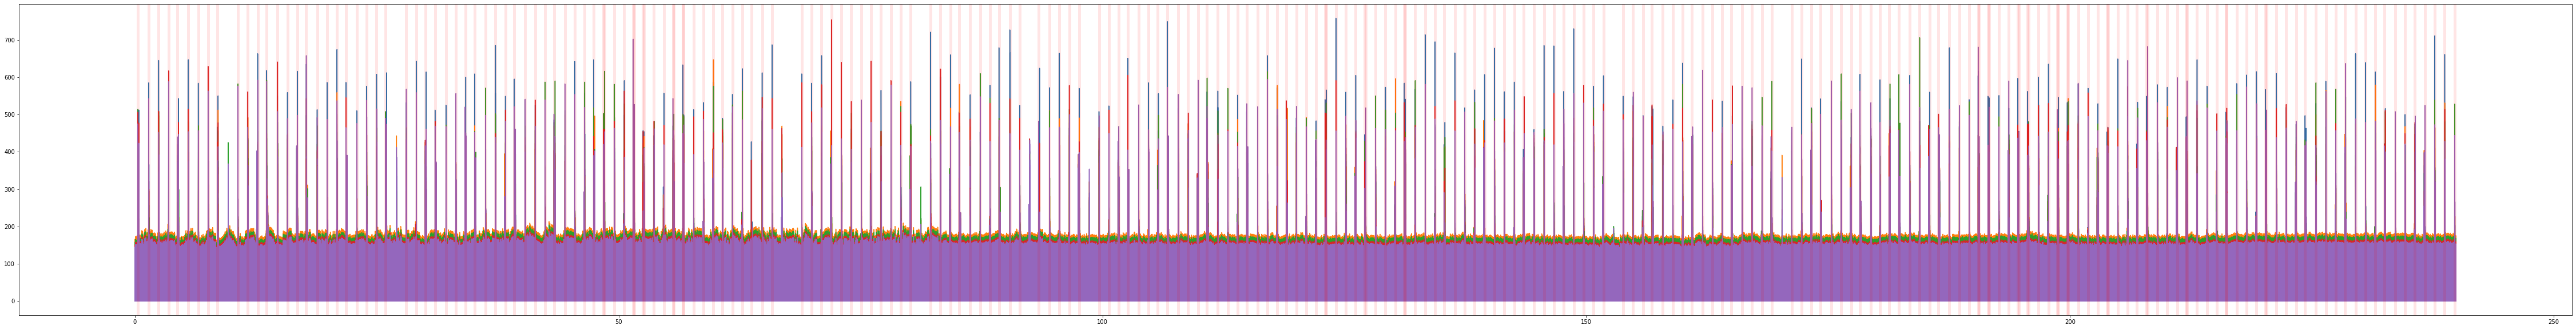

In [ ]:
plt.figure(figsize=(80,10))
plt.plot(t[::500], y[::500])
for xx in (ts - t0):
    plt.axvline(x=xx, color='red', alpha=0.1, linewidth=5)

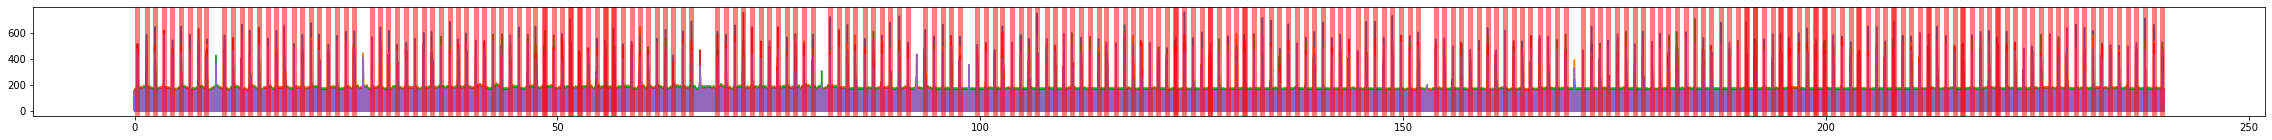

In [ ]:
plt.figure(figsize=(40,2))
plt.plot(t[::500], y[::500])
for xx in (ts - t0):
    plt.axvline(x=xx, color='red', alpha=0.5, linewidth=5)

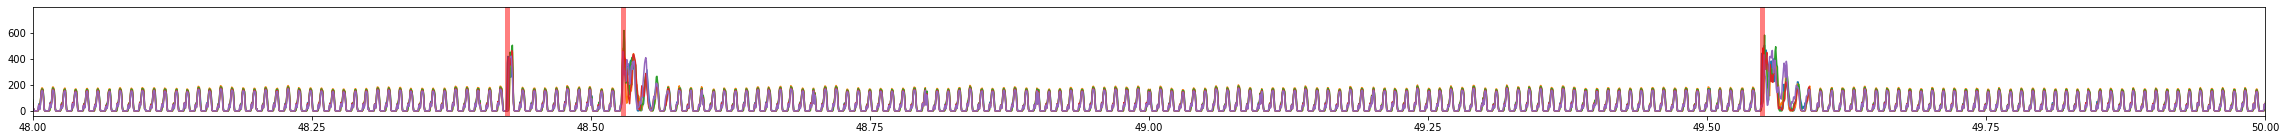

In [ ]:
plt.figure(figsize=(40,2))
plt.plot(t[::500], y[::500])
plt.xlim(48, 50)
for xx in (ts - t0):
    plt.axvline(x=xx, color='red', alpha=0.5, linewidth=5)

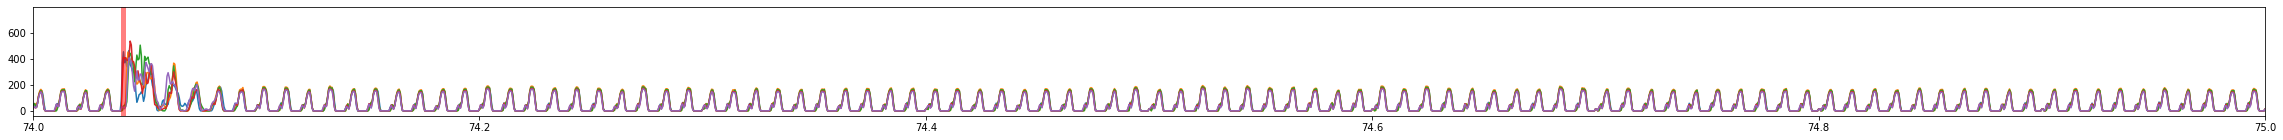

In [ ]:
plt.figure(figsize=(40,2))
plt.plot(t[::500], y[::500])
plt.xlim(74, 75)
for xx in (ts - t0):
    plt.axvline(x=xx, color='red', alpha=0.5, linewidth=5)

In [ ]:
# plt.figure(figsize=(40,2))
# plt.plot(y)
# for xx in indices:
#     plt.axvline(x=int(xx), color='red', alpha=0.5, linewidth=5)

In [ ]:
Est_ZC_stage_1(y[int(70 * fs):int(72*fs)], int(0.004 * fs), 200, run_plot=True, plot_title='zero_crossing')

ValueError: ignored

TypeError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f480c0bcb00> (for post_execute):


KeyboardInterrupt: ignored

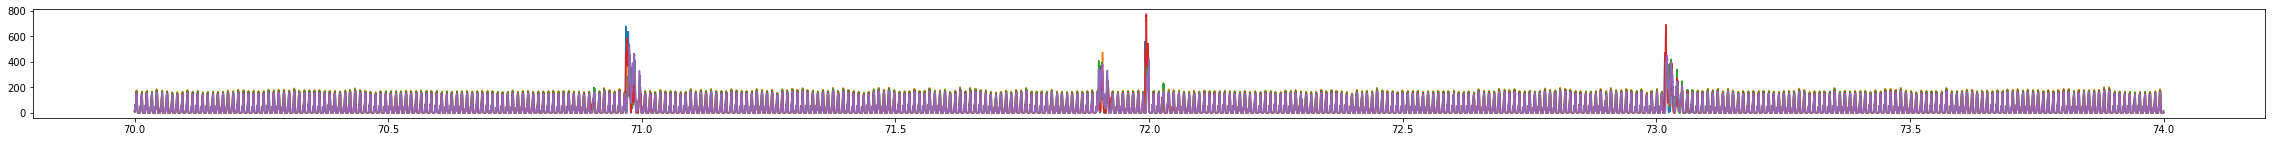

In [ ]:
plt.figure(figsize=(40,2))
plt.plot(t[int(70 * fs):int(74*fs)], y[int(70 * fs):int(74*fs)])
plt.axvline(x=(dt * _ + t[int(70*fs)]), color='red', alpha=0.5, linewidth=5)

## np.diff

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(40,8))
# f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(40,8))

loc = slice(int(0 * fs), int(1.5 * fs))
ax1.plot(t[loc], y[loc])
ax2.plot(t[loc], np.diff(y[loc], prepend=y[loc][0]))
for xx in (ts - t0):
    if xx > t[loc][-1]:
        break
    ax1.axvline(x=xx, color='red', alpha=0.5, linewidth=5)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(40,8))
# f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(40,8))

loc = slice(int(0 * fs), int(20 * fs))
ax1.plot(t[loc], y[loc])
ax2.plot(t[loc], np.clip(np.diff(y[loc], prepend=y[loc][0]),-100, 100))
ax3.plot(t[loc], np.clip(np.diff(np.diff(y[loc], prepend=y[loc][0]), prepend=0),-100, 100))


## View Single Pulse Slices

### ChA

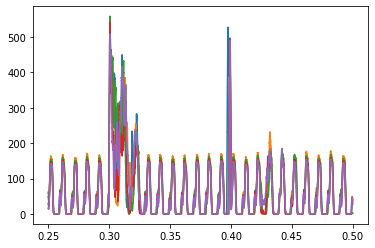

In [ ]:
i = 0
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

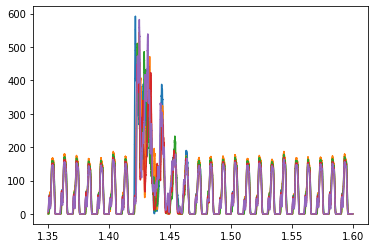

In [ ]:
i = 1.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

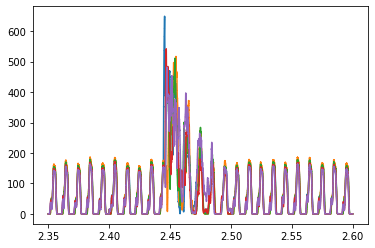

In [ ]:
i = 2.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

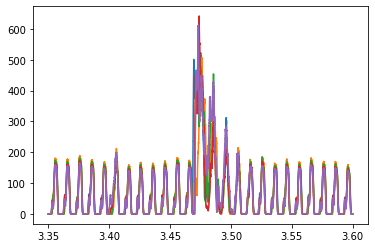

In [ ]:
i = 3.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

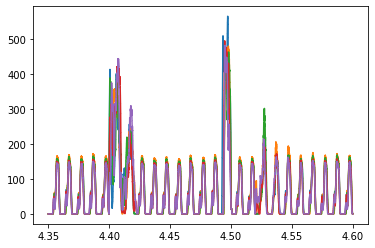

In [ ]:
i = 4.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

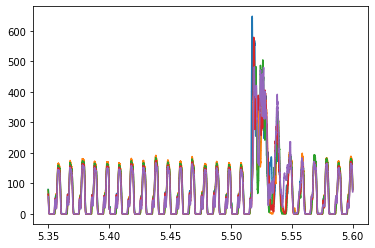

In [ ]:
i = 5.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

### ChB

In [ ]:
i = 0
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

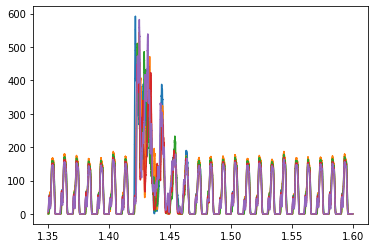

In [ ]:
i = 1.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

In [ ]:
i = 2.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

In [ ]:
i = 3.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

In [ ]:
i = 4.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

In [ ]:
i = 5.1
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

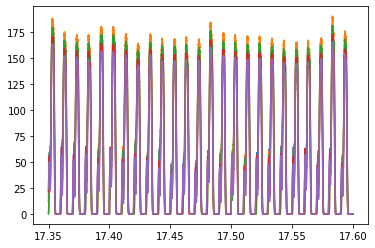

In [ ]:
i = 17.1 #@param {type:"slider", min:1.1, max:100.1, step:1}  
loc = slice(int((i + 0.25) * fs), int((i + 0.5) * fs))
plt.plot(t[loc], y[loc])

In [ ]:
1

# Hmmm